In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
path = "C:\\Users\\Republic Of Gamers\\OneDrive\\Documents\\GitHub\\TSDN-BoyWithLuv\\Source\\Data\\sdm_preprocessed.csv"
df = pd.read_csv(path)
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,day_stayed
0,Bobby Jackson,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,2
1,Leslie Terry,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,6
2,Danny Smith,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,15
3,Andrew Watts,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,30
4,Adrienne Bell,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,20


In [3]:
df.describe()

,Age,Billing Amount,Room Number,day_stayed
count,55392.000000,55392.000000,55392.000000,55392.000000
mean,51.538543,25590.084632,301.119205,15.508774
std,19.602045,14178.657522,115.238552,8.659552
min,13.000000,9.238787,101.000000,1.000000
25%,35.000000,13297.478682,202.000000,8.000000
50%,52.000000,25573.823359,302.000000,15.000000
75%,68.000000,37849.210062,401.000000,23.000000
max,89.000000,52764.276736,500.000000,30.000000


In [4]:
sampled_df = df.sample(n=15000, random_state=42)

In [5]:
columns_to_drop = ['Name', 'Doctor','Hospital','Date of Admission','Discharge Date','Room Number']
sampled_df= sampled_df.drop(columns=columns_to_drop)

In [6]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 31805 to 32892
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 15000 non-null  int64  
 1   Gender              15000 non-null  object 
 2   Blood Type          15000 non-null  object 
 3   Medical Condition   15000 non-null  object 
 4   Insurance Provider  15000 non-null  object 
 5   Billing Amount      15000 non-null  float64
 6   Admission Type      15000 non-null  object 
 7   Medication          15000 non-null  object 
 8   Test Results        15000 non-null  object 
 9   day_stayed          15000 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.3+ MB


In [7]:
df['Medical Condition'].value_counts()

Medical Condition
Arthritis       9297
Diabetes        9284
Hypertension    9224
Obesity         9212
Cancer          9208
Asthma          9167
Name: count, dtype: int64

In [8]:
label_encoder = LabelEncoder()
sampled_df['Gender'] = label_encoder.fit_transform(sampled_df['Gender'])
sampled_df['Medical Condition'] = label_encoder.fit_transform(sampled_df['Medical Condition'])
sampled_df['Blood Type'] = label_encoder.fit_transform(sampled_df['Blood Type'])
sampled_df['Insurance Provider'] = label_encoder.fit_transform(sampled_df['Insurance Provider'])
sampled_df['Admission Type'] = label_encoder.fit_transform(sampled_df['Admission Type'])
sampled_df['Medication'] = label_encoder.fit_transform(sampled_df['Medication'])
sampled_df['Test Results'] = label_encoder.fit_transform(sampled_df['Test Results'])

                         Age    Gender  Blood Type  Medical Condition  \
Age                 1.000000 -0.003078    0.001850          -0.005053   
Gender             -0.003078  1.000000   -0.001107           0.000897   
Blood Type          0.001850 -0.001107    1.000000          -0.000698   
Medical Condition  -0.005053  0.000897   -0.000698           1.000000   
Insurance Provider -0.005086 -0.009789    0.000552           0.006822   
Billing Amount     -0.004210  0.012451    0.004538           0.005380   
Admission Type     -0.007737  0.012215   -0.006026          -0.000325   
Medication         -0.006993  0.004030    0.001110          -0.006511   
Test Results        0.003080  0.016009   -0.010692           0.010277   
day_stayed          0.007088  0.001988    0.011960          -0.019774   

                    Insurance Provider  Billing Amount  Admission Type  \
Age                          -0.005086       -0.004210       -0.007737   
Gender                       -0.009789        0.

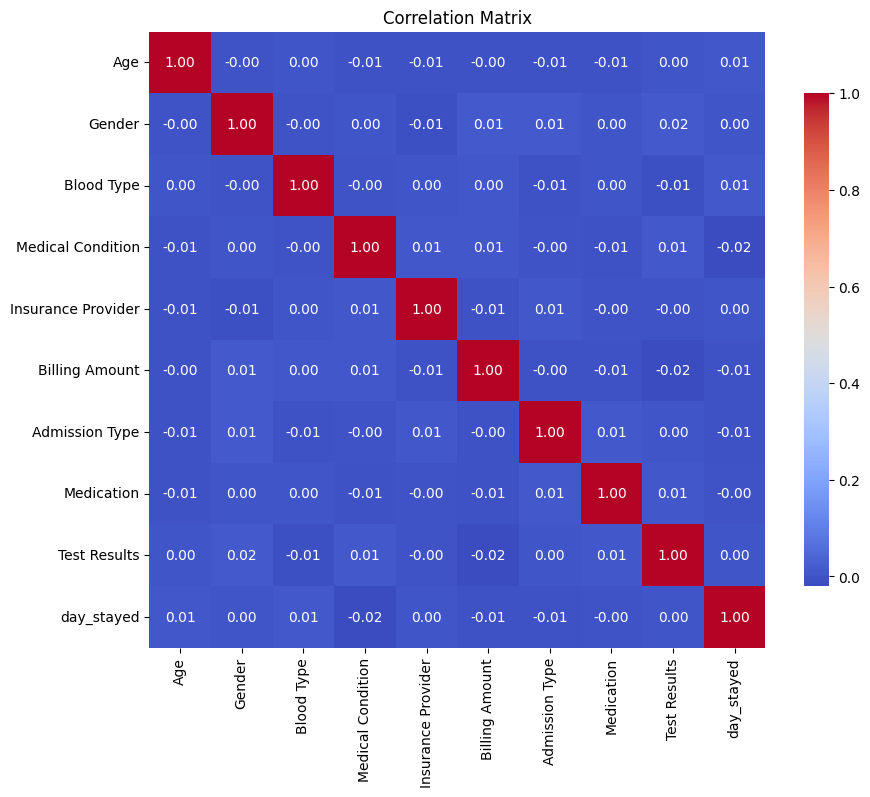

In [9]:
numerical_df = sampled_df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr(method='pearson')  # Can also use 'kendall' or 'spearman'

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [10]:
X = sampled_df.drop('day_stayed', axis=1)  # Replace 'target_variable' with your target column name
y = sampled_df['day_stayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [11]:
# Extract the best parameters from the grid search
best_params = grid_search.best_params_

# Initialize the RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**best_params)

# Fit the model to the full training data
best_rf.fit(X_train, y_train)

# Make predictions on the test set or future data
y_pred = best_rf.predict(X_test)

# Display predictions
print(y_pred)

[15.0657914  16.38287649 15.05556911 ... 16.05050805 15.86214216
 16.96771506]


In [12]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 8.680307197455813
Mean Absolute Error (MAE): 7.541247804609559
R-squared (R²): 0.0012204853727726395


In [13]:
X = sampled_df.drop('day_stayed', axis=1)  # Replace 'target_variable' with your target column name
y = sampled_df['day_stayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
xgb_model = XGBRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


c:\Users\Republic Of Gamers\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [16:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# Extract the best parameters from the grid search
best_params = grid_search.best_params_

# Initialize the XGBRegressor with the best parameters
best_xgb = XGBRegressor(**best_params)

# Fit the model to the full training data
best_xgb.fit(X_train, y_train)

# Make predictions on the test set or future data
y_pred = best_xgb.predict(X_test)

# Display predictions
print("Predictions:", y_pred)

c:\Users\Republic Of Gamers\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [16:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Predictions: [12.12004  23.982609 15.735512 ... 18.032986 15.781694 16.723122]


In [15]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 9.2438767110357
Mean Absolute Error (MAE): 7.8798661133448284
R-squared (R²): -0.1326812505722046


In [16]:
joblib.dump(best_rf, 'rf_day_stayed.pkl')

['rf_day_stayed.pkl']